# Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
    print('Training Data Loaded...')
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
    print('Validation Data Loaded...')
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    print('Testing Data Loaded...')
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

Training Data Loaded...
Validation Data Loaded...
Testing Data Loaded...


# Step 1: Dataset Summary & Exploration

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


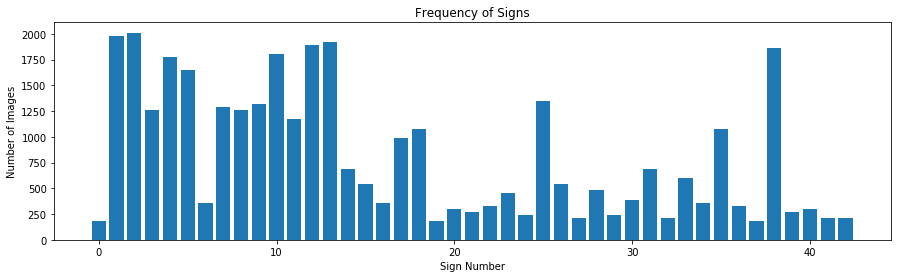

3 Smallest Groups
----------
Speed limit (20km/h)
180 Images
----------
Dangerous curve to the left
180 Images
----------
Go straight or left
180 Images
----------


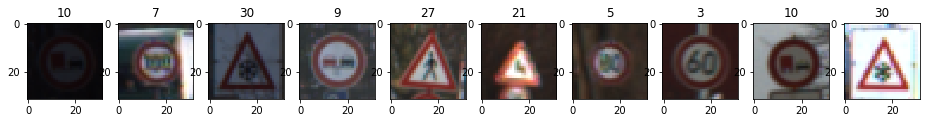

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline
from operator import itemgetter

np.set_printoptions(threshold=np.inf)

#Number of training examples
n_train = X_train.shape[0]

#Number of validation examples
n_validation = X_valid.shape

#Number of testing examples.
n_test = X_test.shape[0]

#Shape of an traffic sign image.
image_shape = X_train.shape[1:3]

#Unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_test))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

def bar_plot(data_set):
    set_labels, set_data = np.unique(data_set, return_counts=True)
    set_labels = set_labels.tolist()
    set_data = set_data.tolist()
    plt.figure(figsize=(15, 4))
    plt.bar(set_labels, set_data)
    plt.title('Frequency of Signs')
    plt.xlabel('Sign Number')
    plt.ylabel('Number of Images')
    plt.show()

def find_min(data_set, number):
    set_labels, set_data = np.unique(data_set, return_counts=True)
    set_labels = set_labels.tolist()
    set_data = set_data.tolist()
    sorting_list = list(zip(set_labels, set_data))
    sorting_list = sorted(sorting_list, key=itemgetter(1))
    sign_names = np.genfromtxt('signnames.csv', dtype="|S50", delimiter=',')
    sign_names = sign_names.tolist()
    del sign_names[0]
    print(number, 'Smallest Groups')
    print('----------')
    for i in range(number):
        j = (sorting_list[i][0])
        print((sign_names[j][1]).decode("utf-8"))
        print(sorting_list[i][1], 'Images')
        print('----------')
         

bar_plot(y_train)
find_min(y_train, 3)

my_randoms = random.sample(range(0, len(y_train)), 11)

fig = plt.figure(figsize=(16,16))
for i in range(1,11):
    index = my_randoms[i]
    image = X_train[index].squeeze()
    a=fig.add_subplot(1,10,i)
    plt.title(y_train[index])
    plt.imshow(image)

The above dataset summary and exploration shows a few insights. For raw numbers it highlights the number of images in each dataset as well as the size of the images. It also shows us there are 43 classes of images to predict. The bar graph shows us the uneven distribution of the data's classes. Some classes are represented by thousands of images while others by less than a couple hundred. The three smallest classes are called out below the graph. It wasn't implented here by some simple image augmentation could be used to boost the amount in certain classes. By flipping or rotating symmetrical signs the dataset could be grown.

Ten images are also randomly selected to be show here to expose the varying level of brightness in the dataset.

# Step 2: Design and Test Model Architecture
## 2.1: Preprocessing

running histogram equalizer
running histogram equalizer
running histogram equalizer


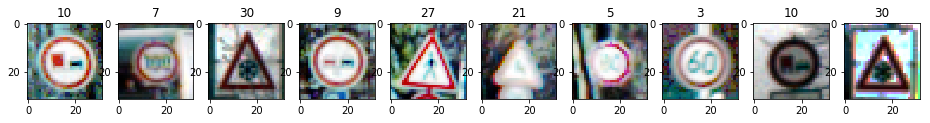

In [3]:
## import time
import matplotlib.pyplot as plt
from skimage import exposure
%matplotlib inline

X_train = X_train.astype(float)
X_test = X_test.astype(float)
X_valid = X_valid.astype(float)
            
def hist_equalize(data_set):
    print('running histogram equalizer')
    for i in range(0,len(data_set)):
        for j in range(3):
            data_set[i,:32,:32,j] = exposure.equalize_hist(data_set[i,:32,:32,j])
        if i % 600 == 0:
            pass #print(len(data_set)-i)
    return data_set

def rescale_intens(data_set):
    print('running intensity rescaler')
    for i in range(0,len(data_set)):
        for j in range(3):
            data_set[i,:32,:32,j] = exposure.rescale_intensity(data_set[i,:32,:32,j], out_range=(0,1))
        if i % 600 == 0:
            pass #print(len(data_set)-i)
    return data_set

def simp_normalizer(data_set):
    print('running simple normalizer')
    for h in range(0, len(data_set)):
        for i in range(32):
            for j in range(32):
                for k in range(3):
                    data_set[h,i,j,k] = (data_set[h,i,j,k] - 128.) / 128.
        if h % 1000 == 0:
            pass #print(len(data_set)-h)
    return data_set

X_train = hist_equalize(X_train)
X_test = hist_equalize(X_test)
X_valid = hist_equalize(X_valid)

fig = plt.figure(figsize=(16,16))
for i in range(1,11):
    index = my_randoms[i]
    image = X_train[index].squeeze()
    a=fig.add_subplot(1,10,i)
    plt.title(y_train[index])
    plt.imshow(image)

In [4]:
X_train = rescale_intens(X_train)
X_test = rescale_intens(X_test)
X_valid = rescale_intens(X_valid)

running intensity rescaler
running intensity rescaler
running intensity rescaler


In the above preprocessing cells the same ten images from earlier are show. After they have been processed with a histogram equalizatoin function their brightness is much more similar and the contrast looks much better for distinguishing the image. Next an intensity rescaling function is used to remap the pixel values from 0-255 to a float between 0 and 1. Both ranges (0, 1) and (-1, 1) were tested against the modified LeNet pipeline and (0, 1) seemed to give better results.

## 2.2: Shuffle Training Data

In [5]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

Training data is shuffled before each run.

# 2.3: LeNet-5 Using TensorFlow

In [62]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

EPOCHS = 100 #10 Original Hyperparameter Try 100
BATCH_SIZE = 32 #128 Original
KEEP_PROB = 1.0

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1 #0.1 original
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob) #Dropout

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

The above model architecture was taken from the LeNet Lab and modified by adding a dropout filter before the last fully connected layer. Dropout was tested throughout the model layers. Being placed and directly before the last fully connected layer gave the best results. Also the dropout probability was tested from 0.1 to 0.9. All values gave surprisingly decent results but around 0.5 seems to work best. 

# 2.4: Train the Model

Training...
EPOCH 1 ...
Validation Accuracy = 0.808
Training Accuracy = 0.847
Time:35
----------
EPOCH 2 ...
Validation Accuracy = 0.877
Training Accuracy = 0.912
Time:70
----------
EPOCH 3 ...
Validation Accuracy = 0.901
Training Accuracy = 0.938
Time:106
----------
EPOCH 4 ...
Validation Accuracy = 0.912
Training Accuracy = 0.956
Time:141
----------
EPOCH 5 ...
Validation Accuracy = 0.924
Training Accuracy = 0.962
Time:177
----------
EPOCH 6 ...
Validation Accuracy = 0.920
Training Accuracy = 0.965
Time:212
----------
EPOCH 7 ...
Validation Accuracy = 0.927
Training Accuracy = 0.976
Time:248
----------
EPOCH 8 ...
Validation Accuracy = 0.933
Training Accuracy = 0.976
Time:284
----------
EPOCH 9 ...
Validation Accuracy = 0.924
Training Accuracy = 0.975
Time:319
----------
EPOCH 10 ...
Validation Accuracy = 0.930
Training Accuracy = 0.982
Time:355
----------
EPOCH 11 ...
Validation Accuracy = 0.932
Training Accuracy = 0.984
Time:390
----------
EPOCH 12 ...
Validation Accuracy = 0.940
T

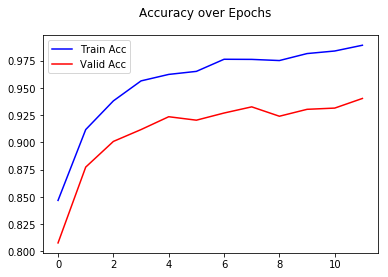

Model saved


In [7]:
import time

x = tf.placeholder(tf.float32, (None, 32, 32, 3)) #None, 32, 32, 3)) Originally
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32)

rate = 0.0012 #0.001 Original

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: KEEP_PROB})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

start_time = time.time()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    epoch_set = []
    train_set = []
    valid_set = []
    
    print("Training...")
    for i in range(EPOCHS):
        
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: KEEP_PROB})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        training_accuracy = evaluate(X_train, y_train)        
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Time:{}".format(int(time.time()-start_time)))
        print("----------")
        
        epoch_set.append(i)
        train_set.append(training_accuracy)
        valid_set.append(validation_accuracy)
        
        if validation_accuracy > 0.94:
            break
        
    plt.plot(epoch_set, train_set, 'b-', label='Train Acc')
    plt.plot(epoch_set, valid_set, 'r-', label='Valid Acc')
    plt.suptitle('Accuracy over Epochs')
    plt.legend()
    plt.show()    
        
    saver.save(sess, './lenet')
    print("Model saved")

The model is trained using the AdamOptimizer TensorFlow function. This function uses the Adam algorithm which is a stochastic optimization algorithm. Hyperparameters were chosen using a manual grid search method. I would tweak one parameter while keeping others fixed and record the effects in a spreadsheet. As I solidified hyperparameter choices I kept experimenting with others and tuned them as best I could in the given time. Once the parameters were chosen I included a "Early Stop" function that breaks the epoch loop once the condition has been met that the validation accuracy is above a given number. 

# 2.5: Evaluate the Model

In [63]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.934


Here we finally run the model on the test data. We also will bring the dropout to zero (1.0 keep rate) so we don't handicap the pipeline now that it's been trained. 93.4% isn't too bad!

running histogram equalizer
running intensity rescaler
Test Accuracy = 1.000


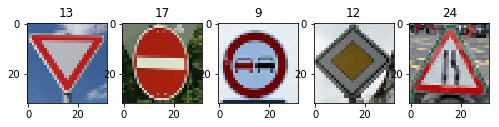

In [87]:
web_images = ['yield_0.jpg', 'no_entry_0.jpg', 'no_passing_0.jpg', 'priority_road_0.jpg', 'road_narrows_right_0.jpg']
image_labels = [13, 17, 9, 12, 24]
image_arrays = np.zeros((5, 32, 32, 3))

#Load new web images and display here.
fig = plt.figure(figsize=(10,10))
for i in range(0,5):
    image = plt.imread(web_images[i])
    image_arrays[i] = image
    a=fig.add_subplot(1,6,i+1)
    plt.title(image_labels[i])
    plt.imshow(image)

#Preprocess images just like the training set:

image_arrays = hist_equalize(image_arrays)
image_arrays = rescale_intens(image_arrays)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(image_arrays, image_labels)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Here we have the five images collected from a random image search online. we have in order: yield, no entry, no passing, priority road, and road narrows right. These were saved from random online sources, cropped down and resized to a 32x32 RGB jpeg image. They were also preprocessed just as all the other data sets have been. On my first run I hadn't set the dropout "keep prob" to 1.0 yet. With the dropout still set at 0.5 I only correctly classified 4 of the 5 images. Once I disabled the dropout it correctly classified each image as seen above.

Looking back now these images seem like they could be easy to classify. Darker or partially obscured images may have been a more interesting experiment but most pictures I saw online were well lit and clear. 

In [118]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    softmax_prob = sess.run(tf.nn.softmax(logits), feed_dict={x: image_arrays, keep_prob: 1.0})

softmax_prob = np.round(prob, 3)
softmax_prob = softmax_prob.tolist()

#for i in range(0,5):
#    print(image_labels[i], web_images[i])
#    print(softmax_prob[i])
#    print('----------')

    
names = np.genfromtxt('signnames.csv', dtype=None, delimiter=',', usecols=(1))
names = names.tolist()
del names[0]
for l in range(0,5):
    for m in range(0, len(softmax_prob[l])):
        softmax_prob[l][m] = round(softmax_prob[l][m], 3)

for j in range(0, 5):
    temp_list = []
    print(web_images[j])
    zipped = list(zip(names, softmax_prob[j]))
    for k in range(0, len(zipped)):
        if zipped[k][1] > 0:
            temp_list.append(zipped[k])
    print(temp_list)
    print('----------')

yield_0.jpg
[(b'Yield', 1.0)]
----------
no_entry_0.jpg
[(b'No entry', 1.0)]
----------
no_passing_0.jpg
[(b'No passing', 1.0)]
----------
priority_road_0.jpg
[(b'Priority road', 1.0)]
----------
road_narrows_right_0.jpg
[(b'General caution', 0.03), (b'Road narrows on the right', 0.86), (b'Children crossing', 0.06), (b'Bicycles crossing', 0.04)]
----------


Above I've crudely printed out to the console the softmax predictions for each of my five new signs. Surprisingly the first four signs were classified perfectly by the network. There were some extremely small negative probabilities but I'm assuming they were rounding errors or floating point math error. The fifth sign, "Road Narrows Right," was the only of the five to have some uncertainty. You can see the network gave it an 86% prediction for the correct label, then much smaller predictions for a couple other labels.

Nick Goumas